In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Dict
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import random
random.seed(43)

In [2]:
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
torch.cuda.is_available()

True

In [4]:
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.2.1
torchvision version: 0.17.1


In [5]:
torch.cuda.device_count()

1

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data

In [7]:
dir = '/app/data'

In [8]:
def find_control_and_count_files(root_directory, target):
    control_path = None
    
    # Traverse the directory hierarchy to find the 'control' folder
    for root, dirs, files in os.walk(root_directory):
        if target in dirs:
            control_path = os.path.join(root, target)
            break
    
    if not control_path:
        print(f'No {target} folder found.')
        return
    
    total_files = 0
    
    # Count files in target folder and all its subdirectories
    for root, dirs, files in os.walk(control_path):
        total_files += len(files)
    
    print(f"Total number of files under the {target} folder: {total_files}")

In [9]:
classes = ['control', 'CBFB_MYH11']

In [10]:
for item in classes:
    find_control_and_count_files(dir, item)

Total number of files under the control folder: 20305
Total number of files under the CBFB_MYH11 folder: 17212


In [11]:
from torch.utils.data import Dataset, DataLoader, random_split

# Data loading function
class CustomDataset(Dataset):
    def __init__(self, dir, classes, image_batch_size=3000, transform=None):
        self.transform = transform
        self.images = []
        self.labels = []
        
        for class_idx, class_name in enumerate(classes):
            class_path = os.path.join(dir, class_name)
            image_paths = [os.path.join(root, file)
                           for root, _, files in os.walk(class_path)
                           for file in files if file.endswith('.tif')]
            random.shuffle(image_paths)
            selected_image_paths = image_paths[:image_batch_size]
            
            for image_path in selected_image_paths:
                with Image.open(image_path) as img:
                    img = img.convert('RGB')
                    self.images.append(np.array(img))
                    self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [12]:
from torchvision import transforms
# Define transforms for the images
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144, 144)),
    transforms.ToTensor()
])

In [13]:
# Create dataset and split it
dataset = CustomDataset(dir=dir, classes=classes, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [14]:
# Split train into train and validation
val_size = int(0.15 * train_size)
train_size = train_size - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [15]:
# Dataloaders
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Define Model

In [16]:
target_height = 144
target_width = 144

In [17]:
class CNNModel(nn.Module):
    def __init__(self, num_layers, num_units, dropout_rate):
        super(CNNModel, self).__init__()
        layers = []
        
        # First convolutional layer
        layers.append(nn.Conv2d(3, num_units, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm2d(num_units))
        layers.append(nn.MaxPool2d(2))
        
        # Add additional convolutional layers
        for _ in range(num_layers - 1):
            layers.append(nn.Conv2d(num_units, num_units * 2, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm2d(num_units * 2))
            layers.append(nn.MaxPool2d(2))
            num_units *= 2
        
        self.conv_layers = nn.Sequential(*layers)
        
        # Fully connected layers
        self.fc1 = nn.Linear(num_units * (target_height // (2 ** num_layers)) * (target_width // (2 ** num_layers)), 512)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 2)  # Assuming binary classification (2 classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for fully connected layers
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


## Hyperparameter Tunning

In [18]:
!pip install optuna -q

In [19]:
import optuna

In [20]:
def create_model(trial: optuna.Trial) -> nn.Module:
    """Define the model architecture."""
    num_layers = trial.suggest_int("num_layers", 2, 3)
    num_neurons_per_layer = trial.suggest_int("num_units", 64, 256, step=64)
    dropout_rate = trial.suggest_float("dropout_rate", 0.3, 0.5)

    model = CNNModel(
        num_layers=num_layers,
        num_units=num_neurons_per_layer,
        dropout_rate=dropout_rate
    )
    return model

In [21]:
EPOCHS = 8

In [22]:
def train_model(model: nn.Module, trial: optuna.Trial) -> float:
    """Train the model and return the best validation loss."""
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-3, log=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Early stopping
    patience = 3
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        with torch.no_grad():
            running_val_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

            avg_val_loss = running_val_loss / len(train_loader)
            val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered")
                break
    
    return best_val_loss


In [23]:
def objective(trial: optuna.Trial) -> float:
    """Objective function for Optuna hyperparameter search."""
    model = create_model(trial)
    return train_model(model, trial)

In [24]:
# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

[I 2024-11-09 03:04:49,885] A new study created in memory with name: no-name-987cd5f6-dec0-42f8-b1a6-9063a0de36e8


Epoch 1: Train Loss: 26.5305, Validation Loss: 3.6344
Epoch 2: Train Loss: 4.4341, Validation Loss: 1.6246
Epoch 3: Train Loss: 2.5260, Validation Loss: 3.0467
Epoch 4: Train Loss: 3.7912, Validation Loss: 2.9443


[I 2024-11-09 03:09:46,348] Trial 0 finished with value: 1.624594350647323 and parameters: {'num_layers': 3, 'num_units': 256, 'dropout_rate': 0.46417950257823903, 'learning_rate': 0.0004381735652309894}. Best is trial 0 with value: 1.624594350647323.


Epoch 5: Train Loss: 3.7136, Validation Loss: 2.1487
Early stopping triggered
Epoch 1: Train Loss: 19.1814, Validation Loss: 1.6872
Epoch 2: Train Loss: 3.2814, Validation Loss: 1.8813
Epoch 3: Train Loss: 4.4234, Validation Loss: 2.5904


[I 2024-11-09 03:13:38,207] Trial 1 finished with value: 1.6871694531652428 and parameters: {'num_layers': 3, 'num_units': 192, 'dropout_rate': 0.3611973523000103, 'learning_rate': 0.0006787212723319971}. Best is trial 0 with value: 1.624594350647323.


Epoch 4: Train Loss: 3.9493, Validation Loss: 4.1826
Early stopping triggered
Epoch 1: Train Loss: 27.0699, Validation Loss: 10.7211
Epoch 2: Train Loss: 4.8948, Validation Loss: 2.5903
Epoch 3: Train Loss: 4.3893, Validation Loss: 4.5917
Epoch 4: Train Loss: 6.5580, Validation Loss: 7.1464
Epoch 5: Train Loss: 3.0044, Validation Loss: 1.5232
Epoch 6: Train Loss: 3.2456, Validation Loss: 1.6134
Epoch 7: Train Loss: 3.1521, Validation Loss: 1.9241


[I 2024-11-09 03:20:17,179] Trial 2 finished with value: 1.5231981254673954 and parameters: {'num_layers': 2, 'num_units': 128, 'dropout_rate': 0.37161091438708393, 'learning_rate': 0.0009054852572916622}. Best is trial 2 with value: 1.5231981254673954.


Epoch 8: Train Loss: 2.3581, Validation Loss: 3.4668
Early stopping triggered
Epoch 1: Train Loss: 28.4772, Validation Loss: 6.0138
Epoch 2: Train Loss: 4.3237, Validation Loss: 4.7351
Epoch 3: Train Loss: 3.8985, Validation Loss: 14.3351
Epoch 4: Train Loss: 4.8311, Validation Loss: 15.7762


[I 2024-11-09 03:24:33,308] Trial 3 finished with value: 4.735129727861275 and parameters: {'num_layers': 2, 'num_units': 128, 'dropout_rate': 0.4996324724083356, 'learning_rate': 0.0006358154954851214}. Best is trial 2 with value: 1.5231981254673954.


Epoch 5: Train Loss: 4.8956, Validation Loss: 15.4264
Early stopping triggered
Epoch 1: Train Loss: 14.7956, Validation Loss: 6.8012
Epoch 2: Train Loss: 6.7893, Validation Loss: 7.8761
Epoch 3: Train Loss: 4.2681, Validation Loss: 1.2868
Epoch 4: Train Loss: 1.8631, Validation Loss: 4.4386
Epoch 5: Train Loss: 1.4069, Validation Loss: 2.2719
Epoch 6: Train Loss: 0.9008, Validation Loss: 0.7134
Epoch 7: Train Loss: 0.5388, Validation Loss: 0.1217


[I 2024-11-09 03:31:57,904] Trial 4 finished with value: 0.1216531922492873 and parameters: {'num_layers': 2, 'num_units': 128, 'dropout_rate': 0.3668925059415144, 'learning_rate': 0.00018297302506149654}. Best is trial 4 with value: 0.1216531922492873.


Epoch 8: Train Loss: 0.3192, Validation Loss: 0.4636


## Re-Train with Best Hypermeters

In [26]:
best_params = study.best_params

print("  Hyperparameters: ")
for key, value in best_params.items():
    print(f"    {key}: {value}")

  Hyperparameters: 
    num_layers: 2
    num_units: 128
    dropout_rate: 0.3668925059415144
    learning_rate: 0.00018297302506149654


In [29]:
best_model = CNNModel(
    num_layers=best_params['num_layers'],
    num_units=best_params['num_units'],
    dropout_rate=best_params['dropout_rate']
).to(device)

In [30]:
# Re-train the model with the best hyperparameters and early stopping
optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
criterion = nn.CrossEntropyLoss()

In [31]:
train_losses = []
val_losses = []

In [32]:
EPOCHS = 50

In [34]:
# Same training loop with early stopping
patience = 3
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(EPOCHS):
    best_model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
    
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase (use a validation dataset or just monitor on training set for now)
    best_model.eval()
    with torch.no_grad():
        running_val_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = best_model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(train_loader)
        val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered")
            break

Epoch 1: Train Loss: 12.7738, Validation Loss: 11.9394
Epoch 2: Train Loss: 7.9113, Validation Loss: 4.4623
Epoch 3: Train Loss: 4.0056, Validation Loss: 1.1822
Epoch 4: Train Loss: 2.2365, Validation Loss: 1.4406
Epoch 5: Train Loss: 1.0781, Validation Loss: 0.4042
Epoch 6: Train Loss: 0.7951, Validation Loss: 0.1759
Epoch 7: Train Loss: 0.5628, Validation Loss: 0.1112
Epoch 8: Train Loss: 0.3066, Validation Loss: 0.0838
Epoch 9: Train Loss: 0.2260, Validation Loss: 0.0402
Epoch 10: Train Loss: 0.1449, Validation Loss: 0.0461
Epoch 11: Train Loss: 0.1428, Validation Loss: 0.3069
Epoch 12: Train Loss: 0.1868, Validation Loss: 0.0584
Early stopping triggered


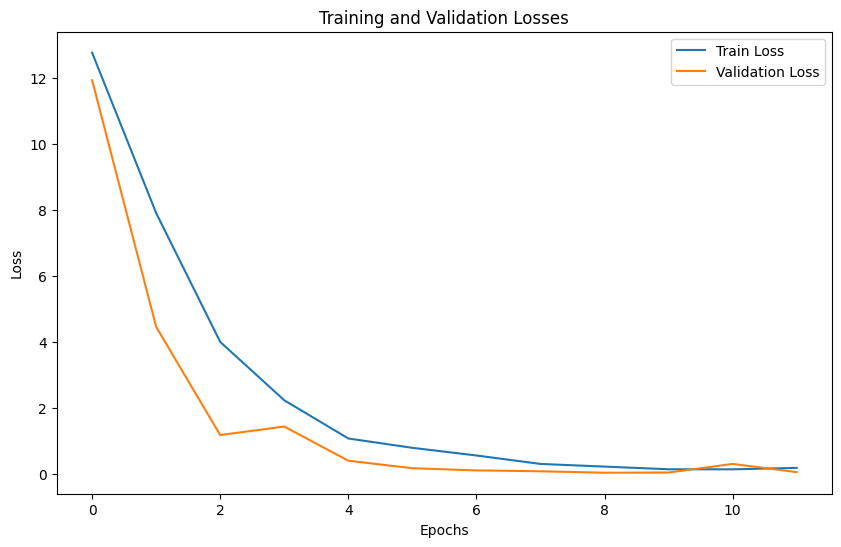

In [35]:
# Plot training and validation losses
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    plt.show()

plot_losses(train_losses, val_losses)

## Validation with Test Data

In [47]:
best_model.eval()
with torch.no_grad():
    y_pred_list = []
    y_true_list = []

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_pred_list.extend(predicted.cpu().numpy())
        y_true_list.extend(labels.cpu().numpy())


In [44]:
!pip install scikit-learn -q

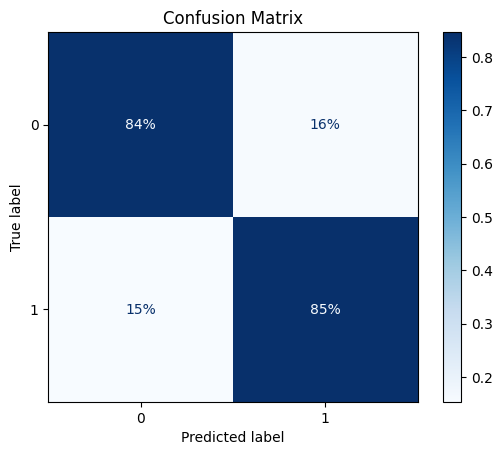

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_true_list, y_pred_list)
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

# Define class labels
classes = np.unique(y_true_list)

# Print confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format=".0%")
plt.title('Confusion Matrix')
plt.show()

In [49]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       600
           1       0.84      0.85      0.85       600

    accuracy                           0.84      1200
   macro avg       0.85      0.84      0.84      1200
weighted avg       0.85      0.84      0.84      1200

